<a href="https://colab.research.google.com/github/AzucenaMV/CapstoneProject/blob/master/SP500_Sub_Industry_Aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Data Prep

In [0]:
# Get tickers from S&P 500 companies 
data = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
table = data[0]
table_sector = table[['Ticker Symbol','GICS Sector', 'GICS Sub Industry']]
table_sector.columns = ['tic', 'sector', 'sub_industry']
table_sector = table_sector.apply(lambda x: x.str.lower() if x.name in ['sub_industry','sector'] else x)

In [0]:
table_sector

,tic,sector,sub_industry
0,MMM,industrials,industrial conglomerates
1,ABT,health care,health care equipment
2,ABBV,health care,pharmaceuticals
3,ABMD,health care,health care equipment
4,ACN,information technology,it consulting & other services
...,...,...,...
500,YUM,consumer discretionary,restaurants
501,ZBRA,information technology,electronic equipment & instruments
502,ZBH,health care,health care equipment
503,ZION,financials,regional banks


In [0]:
sub_industry_count = pd.DataFrame(table_sector['sub_industry'].value_counts()).reset_index()
sub_industry_count.columns = ['sub_industry', 'count']
sub_industry_count

,sub_industry,count
0,health care equipment,19
1,electric utilities,13
2,semiconductors,13
3,industrial machinery,13
4,data processing & outsourced services,12
...,...,...
123,technology distributors,1
124,automotive retail,1
125,housewares & specialties,1
126,hotel & resort reits,1


In [0]:
single_stock = list(table_sector['sub_industry'].value_counts().index[table_sector['sub_industry'].value_counts() == 1])
two_stock = list(table_sector['sub_industry'].value_counts().index[table_sector['sub_industry'].value_counts() == 2])

In [0]:
#single_stock
two_stock

['department stores',
 'advertising',
 'trucking',
 'industrial reits',
 'electronic components',
 'auto parts & equipment',
 'electronic manufacturing services',
 'home furnishings',
 'publishing',
 'home improvement retail',
 'tobacco',
 'integrated telecommunication services',
 'industrial gases',
 'construction materials',
 'broadcasting',
 'automobile manufacturers',
 'construction & engineering',
 'distillers & vintners',
 'independent power producers & energy traders',
 'hypermarkets & super centers',
 'diversified support services']

In [0]:
len(table_sector['sector'].unique()), len(table_sector['sub_industry'].unique())

(11, 128)

In [0]:
stock = pd.read_csv('https://raw.githubusercontent.com/AzucenaMV/CapstoneProject/master/data/sp500/wrds_sp500_stock_price_share.csv')
stock = stock[['datadate', 'tic', 'prccd', 'cshoc']]
stock.columns = ['date', 'tic', 'price', 'share']
stock['date'] = pd.to_datetime(stock['date'],format='%Y%M%d').dt.strftime('%Y-%M-%d')
stock['market_val'] = stock['price'] * stock['share']

stock.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date,tic,price,share,market_val
0,2009-12-31,AAMRQ,7.73,332456000.0,2.569885e+09
1,2010-01-04,AAMRQ,7.72,332456000.0,2.566560e+09
2,2010-01-05,AAMRQ,8.36,332456000.0,2.779332e+09
3,2010-01-06,AAMRQ,8.11,332456000.0,2.696218e+09
4,2010-01-07,AAMRQ,8.25,332456000.0,2.742762e+09


In [0]:
stock = stock.merge(table_sector, on='tic')
stock.head()

,date,tic,price,share,market_val,sector,sub_industry
0,2013-12-09,AAL,24.60,219297000.0,5.394706e+09,industrials,airlines
1,2013-12-10,AAL,24.88,219297000.0,5.456109e+09,industrials,airlines
2,2013-12-11,AAL,25.99,219297000.0,5.699529e+09,industrials,airlines
3,2013-12-12,AAL,25.45,219297000.0,5.581109e+09,industrials,airlines
4,2013-12-13,AAL,26.23,219297000.0,5.752160e+09,industrials,airlines


In [0]:
dic_sub_industry_df ={} # df for each sub industry
for sub in list(table_sector['sub_industry'].unique()):
  dic_sub_industry_df[sub] = stock.loc[stock['sub_industry']==sub, :]

In [0]:
temp = stock.groupby('date')['market_val', 'share'].agg('sum')
df_market = pd.DataFrame(temp['market_val'] / temp['share'], columns=['market']).reset_index()
df_market

,date,market
0,2009-12-31,33.250038
1,2010-01-04,33.763571
2,2010-01-05,33.871269
3,2010-01-06,33.862443
4,2010-01-07,34.003506
...,...,...
2515,2019-12-24,94.187324
2516,2019-12-26,94.687233
2517,2019-12-27,94.680833
2518,2019-12-30,94.135326


In [0]:
df_price_agg = df_market

for sub, df in dic_sub_industry_df.items():
  temp = df.groupby('date')['market_val', 'share'].agg('sum')
  df_outcome = pd.DataFrame(temp['market_val'] / temp['share'], columns=[sub]).reset_index()
  df_price_agg = df_price_agg.merge(df_outcome, on='date', how='left') 

In [0]:
df_price_agg = df_price_agg.set_index('date')
df_price_agg

,market,industrial conglomerates,health care equipment,pharmaceuticals,it consulting & other services,interactive home entertainment,application software,semiconductors,automotive retail,independent power producers & energy traders,life & health insurance,industrial gases,internet services & infrastructure,airlines,specialty chemicals,office reits,biotechnology,health care supplies,building products,data processing & outsourced services,electric utilities,property & casualty insurance,interactive media & services,tobacco,internet & direct marketing retail,paper packaging,multi-utilities,consumer finance,specialized reits,water utilities,asset management & custody banks,health care distributors,electrical components & equipment,electronic components,managed health care,insurance brokers,oil & gas exploration & production,residential reits,"technology hardware, storage & peripherals",semiconductor equipment,...,electronic equipment & instruments,automobile manufacturers,systems software,movies & entertainment,copper,apparel retail,consumer electronics,specialized consumer services,motorcycle manufacturers,leisure products,health care reits,oil & gas drilling,oil & gas refining & marketing,home improvement retail,hotel & resort reits,life sciences tools & services,advertising,electronic manufacturing services,construction & engineering,trucking,oil & gas storage & transportation,food retail,casinos & gaming,home furnishings,distributors,department stores,construction materials,brewers,housewares & specialties,gold,publishing,steel,thrifts & mortgage finance,environmental & facilities services,human resource & employment services,food distributors,wireless telecommunication services,trading companies & distributors,drug retail,household appliances
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-31,33.250038,20.834651,42.962127,31.580846,79.570344,12.346137,25.677341,23.184689,40.48,16.168264,36.804522,80.616220,35.255716,12.023977,35.502226,65.006778,47.483337,30.907118,25.345372,48.624154,33.316983,31.906943,619.980000,33.308458,51.665520,27.772353,33.755282,33.647852,43.397689,22.41,44.146167,31.318729,45.714395,21.977370,38.024261,26.951876,62.311542,35.336285,67.403769,18.217677,...,31.506855,10.000000,30.387047,27.639287,80.29,26.536483,30.70,22.62,25.20,32.06,37.108762,39.88,17.475954,26.359409,11.67,47.348121,19.781122,23.841893,27.094042,31.913980,24.678472,20.53,17.195477,28.842944,19.59,23.851885,62.303050,45.16,15.010,47.31,NaN,46.65,16.70,30.166614,26.73,27.94,NaN,9.81,36.72,80.66
2010-01-04,33.763571,21.207102,43.225729,32.127135,80.607593,12.584832,26.038652,23.540966,40.38,16.500513,37.947339,82.213269,35.486709,11.839700,36.854109,64.744480,48.052607,31.121354,25.874340,49.014704,33.340476,31.926390,626.750000,33.947395,51.900418,28.176744,33.798236,33.987311,43.761360,22.65,44.895012,31.737913,46.421300,22.178728,39.218242,26.790410,64.199723,34.983054,68.534105,18.643435,...,31.531350,10.280000,30.856759,27.643619,83.46,26.229988,32.18,22.66,25.46,32.54,36.701443,41.98,18.665005,26.113329,11.82,47.221342,20.056031,24.336381,27.658131,32.205100,25.282004,20.48,18.897157,29.139186,19.69,24.165510,62.939879,45.92,15.200,48.45,NaN,47.79,16.75,30.522417,27.12,28.10,NaN,10.04,37.30,81.95
2010-01-05,33.871269,21.246574,43.267179,31.820743,79.810617,12.702413,26.016745,23.692020,40.14,16.502039,38.823001,81.032152,35.562527,12.638237,37.481396,64.622706,47.744112,30.825371,26.443363,48.913618,32.930558,31.865844,623.990000,33.746663,51.980118,28.614430,33.383736,34.377560,44.263436,22.88,45.240170,32.011450,46.350448,22.146480,39.394576,26.447375,64.184216,34.941582,68.677665,18.489744,...,31.575047,10.960000,30.869495,27.537169,83.96,26.534123,32.26,22.34,25.65,32.18,36.851076,44.43,19.232099,26.114526,12.09,47.135316,19.952610,23.972720,27.904762,32.417552,25.449366,20.24,20.455316,28.928498,19.83,23.832665,62.762318,45.37,15.110,48.58,NaN,48.12,16.85,30.452079,27.46,27.98,

In [0]:
# Splitting sectors
chemicals = {'specialty':['specialty chemicals'],'non-specialty':['fertilizers & agricultural chemicals','commodity chemicals','diversified chemicals']}
oil = {'upstream':['oil & gas exploration & production','oil & gas drilling'],'midstream':['oil & gas storage & transportation'],'downstream':['oil & gas refining & marketing'],'integrated':['integrated oil & gas'],'services':['oil & gas equipment & services']}
airline = {'legacy':['airlines']}
industry_dicts = [chemicals,oil,airline]

dic_sub_industry_df ={} # df for each sub industry
for dic in industry_dicts:
  for sub in dic.keys():
    dic_sub_industry_df[sub] = stock.loc[stock['sub_industry'].isin(dic[sub]), :]

In [0]:
remove_cols = []
for ind in industry_dicts:
  remove_cols += list(ind.values()) 
remove_cols = [item for sublist in remove_cols for item in sublist]
remove_cols

['specialty chemicals',
 'fertilizers & agricultural chemicals',
 'commodity chemicals',
 'diversified chemicals',
 'oil & gas exploration & production',
 'oil & gas drilling',
 'oil & gas storage & transportation',
 'oil & gas refining & marketing',
 'integrated oil & gas',
 'oil & gas equipment & services',
 'airlines']

In [0]:
df_price_agg_3ind = df_market[['date']]
for sub, df in dic_sub_industry_df.items():
  temp = df.groupby('date')['market_val', 'share'].agg('sum')
  df_outcome = pd.DataFrame(temp['market_val'] / temp['share'], columns=[sub])
  df_price_agg_3ind = df_price_agg_3ind.merge(df_outcome, on='date', how='left') 

In [0]:
df_price_agg_3ind

,date,specialty,non-specialty,upstream,midstream,downstream,integrated,services,legacy
0,2009-12-31,35.502226,61.699924,61.808103,24.678472,17.475954,70.332884,49.083616,12.023977
1,2010-01-04,36.854109,63.452263,63.701038,25.282004,18.665005,71.686781,50.792623,11.839700
2,2010-01-05,37.481396,64.457564,63.740866,25.449366,19.232099,72.044686,51.158975,12.638237
3,2010-01-06,37.850241,66.455050,64.336719,26.090430,19.648771,72.457241,52.252925,12.423343
4,2010-01-07,37.961343,66.449674,63.880724,25.908983,19.778143,72.281186,52.543386,12.782049
...,...,...,...,...,...,...,...,...,...
2515,2019-12-24,125.996081,44.497236,47.287485,27.758467,82.411385,84.693445,30.368794,55.942319
2516,2019-12-26,126.056433,44.823129,47.446838,27.846157,81.734066,84.852320,30.102535,56.107837
2517,2019-12-27,125.983491,44.479337,47.220642,27.663143,80.957385,84.559107,29.998547,55.365235
2518,2019-12-30,125.248037,44.082869,47.077216,27.481723,80.428949,84.142079,30.282423,55.044134


In [0]:
df_price_agg = df_price_agg.merge(df_price_agg_3ind, on='date').drop(columns=remove_cols)
df_price_agg

,date,market,industrial conglomerates,health care equipment,pharmaceuticals,it consulting & other services,interactive home entertainment,application software,semiconductors,automotive retail,independent power producers & energy traders,life & health insurance,industrial gases,internet services & infrastructure,office reits,biotechnology,health care supplies,building products,data processing & outsourced services,electric utilities,property & casualty insurance,interactive media & services,tobacco,internet & direct marketing retail,paper packaging,multi-utilities,consumer finance,specialized reits,water utilities,asset management & custody banks,health care distributors,electrical components & equipment,electronic components,managed health care,insurance brokers,residential reits,"technology hardware, storage & peripherals",semiconductor equipment,auto parts & equipment,agricultural products,...,apparel retail,consumer electronics,specialized consumer services,motorcycle manufacturers,leisure products,health care reits,home improvement retail,hotel & resort reits,life sciences tools & services,advertising,electronic manufacturing services,construction & engineering,trucking,food retail,casinos & gaming,home furnishings,distributors,department stores,construction materials,brewers,housewares & specialties,gold,publishing,steel,thrifts & mortgage finance,environmental & facilities services,human resource & employment services,food distributors,wireless telecommunication services,trading companies & distributors,drug retail,household appliances,specialty,non-specialty,upstream,midstream,downstream,integrated,services,legacy
0,2009-12-31,33.250038,20.834651,42.962127,31.580846,79.570344,12.346137,25.677341,23.184689,40.48,16.168264,36.804522,80.616220,35.255716,65.006778,47.483337,30.907118,25.345372,48.624154,33.316983,31.906943,619.980000,33.308458,51.665520,27.772353,33.755282,33.647852,43.397689,22.41,44.146167,31.318729,45.714395,21.977370,38.024261,26.951876,35.336285,67.403769,18.217677,33.220000,31.31,...,26.536483,30.70,22.62,25.20,32.06,37.108762,26.359409,11.67,47.348121,19.781122,23.841893,27.094042,31.913980,20.53,17.195477,28.842944,19.59,23.851885,62.303050,45.16,15.010,47.31,NaN,46.65,16.70,30.166614,26.73,27.94,NaN,9.81,36.72,80.66,35.502226,61.699924,61.808103,24.678472,17.475954,70.332884,49.083616,12.023977
1,2010-01-04,33.763571,21.207102,43.225729,32.127135,80.607593,12.584832,26.038652,23.540966,40.38,16.500513,37.947339,82.213269,35.486709,64.744480,48.052607,31.121354,25.874340,49.014704,33.340476,31.926390,626.750000,33.947395,51.900418,28.176744,33.798236,33.987311,43.761360,22.65,44.895012,31.737913,46.421300,22.178728,39.218242,26.790410,34.983054,68.534105,18.643435,33.780000,31.47,...,26.229988,32.18,22.66,25.46,32.54,36.701443,26.113329,11.82,47.221342,20.056031,24.336381,27.658131,32.205100,20.48,18.897157,29.139186,19.69,24.165510,62.939879,45.92,15.200,48.45,NaN,47.79,16.75,30.522417,27.12,28.10,NaN,10.04,37.30,81.95,36.854109,63.452263,63.701038,25.282004,18.665005,71.686781,50.792623,11.839700
2,2010-01-05,33.871269,21.246574,43.267179,31.820743,79.810617,12.702413,26.016745,23.692020,40.14,16.502039,38.823001,81.032152,35.562527,64.622706,47.744112,30.825371,26.443363,48.913618,32.930558,31.865844,623.990000,33.746663,51.980118,28.614430,33.383736,34.377560,44.263436,22.88,45.240170,32.011450,46.350448,22.146480,39.394576,26.447375,34.941582,68.677665,18.489744,35.390000,31.64,...,26.534123,32.26,22.34,25.65,32.18,36.851076,26.114526,12.09,47.135316,19.952610,23.972720,27.904762,32.417552,20.24,20.455316,28.928498,19.83,23.832665,62.762318,45.37,15.110,48.58,NaN,48.12,16.85,30.452079,27.46,27.98,NaN,9.93,37.00,81.78,37.481396,64.457564,63.740866,25.449366,19.232099,72.044686,51.158975,12.638237
3,2010-01-06,33.862443,21.247715,43.560712,31.993936,79.545591,12.562386,25.759776,23.561508,40.49,16.547965,39.158026,81.174625,35.401195,64.519960,48.062236,30.805496,26.982194,48.663408,33.144308,31.

In [0]:
df_price_agg.to_csv('sp500_price_agg.csv', index=False)

In [0]:
# first calcualte the percentage change
# relative change w.r.t. the market
df_relative_change = df_price_agg.pct_change().div(df_price_agg['market'].pct_change(), axis=0)
df_relative_change.head()

,market,industrial conglomerates,health care equipment,pharmaceuticals,it consulting & other services,interactive home entertainment,application software,semiconductors,automotive retail,independent power producers & energy traders,life & health insurance,industrial gases,internet services & infrastructure,airlines,specialty chemicals,office reits,biotechnology,health care supplies,building products,data processing & outsourced services,electric utilities,property & casualty insurance,interactive media & services,tobacco,internet & direct marketing retail,paper packaging,multi-utilities,consumer finance,specialized reits,water utilities,asset management & custody banks,health care distributors,electrical components & equipment,electronic components,managed health care,insurance brokers,oil & gas exploration & production,residential reits,"technology hardware, storage & peripherals",semiconductor equipment,...,electronic equipment & instruments,automobile manufacturers,systems software,movies & entertainment,copper,apparel retail,consumer electronics,specialized consumer services,motorcycle manufacturers,leisure products,health care reits,oil & gas drilling,oil & gas refining & marketing,home improvement retail,hotel & resort reits,life sciences tools & services,advertising,electronic manufacturing services,construction & engineering,trucking,oil & gas storage & transportation,food retail,casinos & gaming,home furnishings,distributors,department stores,construction materials,brewers,housewares & specialties,gold,publishing,steel,thrifts & mortgage finance,environmental & facilities services,human resource & employment services,food distributors,wireless telecommunication services,trading companies & distributors,drug retail,household appliances
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-04,1.0,1.157463,0.397271,1.120011,0.844026,1.251801,0.911077,0.994970,-0.159950,1.330532,2.010479,1.282684,0.424222,-0.992313,2.465514,-0.261252,0.776248,0.448805,1.351310,0.520055,0.045655,0.039462,0.707025,1.242018,0.294376,0.942783,0.082392,0.653212,0.542582,0.693415,1.098306,0.866612,1.001226,0.593222,2.033108,-0.387897,1.962001,-0.647235,1.085794,1.513193,...,0.050339,1.812934,1.000846,0.010147,2.556359,-0.747833,3.121385,0.114496,0.668031,0.969397,-0.710694,3.409480,4.405382,-0.604456,0.832232,-0.173368,0.899833,1.342886,1.348026,0.590628,1.583456,-0.157690,6.407487,0.665013,0.330514,0.851358,0.661817,1.089642,0.819591,1.560184,NaN,1.582258,0.193855,0.763672,0.944691,0.370781,NaN,1.518039,1.022703,1.035513
2010-01-05,1.0,0.583505,0.300618,-2.989808,-3.099613,2.929068,-0.263763,2.011615,-1.863300,0.028987,7.234247,-4.503902,0.669799,21.144264,5.336032,-0.589646,-2.012651,-2.981578,6.894426,-0.646552,-3.854454,-0.594525,-1.380552,-1.853742,0.481426,4.869791,-3.844746,3.599664,3.596801,3.183447,2.410227,2.701937,-0.478487,-0.455825,1.409573,-4.014180,-0.075721,-0.371649,0.656696,-2.584410,...,0.434453,20.737373,0.129396,-1.207221,1.878147,3.635018,0.779367,-4.427188,2.339554,-3.468350,1.278155,18.296229,9.525006,0.014376,7.161174,-0.571128,-1.616588,-4.684672,2.795518,2.068118,2.075306,-3.673831,25.849564,-2.266732,2.229052,-4.318015,-0.884422,-3.754903,-1.856252,0.841177,NaN,2.164785,1.871643,-0.722453,3.930313,-1.338791,NaN,-3.434764,-2.521450,-0.650336
2010-01-06,1.0,-0.205980,-26.032902,-20.885422,12.742364,42.300855,37.901047,21.138383,-33.459060,-10.679305,-33.113959,-6.746799,17.408122,65.247016,-37.761736,6.101004,-25.568104,2.474162,-78.191455,19.628961,-24.907462,22.902589,96.732887,-17.182247,70.050042,39.907405,-7.029749,-42.438048,7.074866,-20.125574,

## Correlation

In [0]:
stock_agg = pd.read_csv('https://raw.githubusercontent.com/AzucenaMV/CapstoneProject/master/data/sp500/wrds_sp500_price_agg.csv')
stock_agg['date'] = pd.to_datetime(stock_agg['date'])

In [0]:
stock_agg.head()

,date,industrial conglomerates,health care equipment,pharmaceuticals,it consulting & other services,interactive home entertainment,application software,semiconductors,automotive retail,independent power producers & energy traders,life & health insurance,industrial gases,internet services & infrastructure,airlines,specialty chemicals,office reits,biotechnology,health care supplies,building products,data processing & outsourced services,electric utilities,property & casualty insurance,interactive media & services,tobacco,internet & direct marketing retail,paper packaging,multi-utilities,consumer finance,specialized reits,water utilities,asset management & custody banks,health care distributors,electrical components & equipment,electronic components,managed health care,insurance brokers,oil & gas exploration & production,residential reits,"technology hardware, storage & peripherals",semiconductor equipment,...,electronic equipment & instruments,automobile manufacturers,systems software,movies & entertainment,copper,apparel retail,consumer electronics,specialized consumer services,motorcycle manufacturers,leisure products,health care reits,oil & gas drilling,oil & gas refining & marketing,home improvement retail,hotel & resort reits,life sciences tools & services,advertising,electronic manufacturing services,construction & engineering,trucking,oil & gas storage & transportation,food retail,casinos & gaming,home furnishings,distributors,department stores,construction materials,brewers,housewares & specialties,gold,publishing,steel,thrifts & mortgage finance,environmental & facilities services,human resource & employment services,food distributors,wireless telecommunication services,trading companies & distributors,drug retail,household appliances
0,2009-12-31,20.834651,42.962127,31.580846,79.570344,12.346137,25.677341,23.184689,40.48,16.168264,36.804522,80.616220,35.255716,12.023977,35.502226,65.006778,47.483337,30.907118,25.345372,48.624154,33.316983,31.906943,619.98,33.308458,51.665520,27.772353,33.755282,33.647852,43.397689,22.41,44.146167,31.318729,45.714395,21.977370,38.024261,26.951876,62.311542,35.336285,67.403769,18.217677,...,31.506855,10.00,30.387047,27.639287,80.29,26.536483,30.70,22.62,25.20,32.06,37.108762,39.88,17.475954,26.359409,11.67,47.348121,19.781122,23.841893,27.094042,31.913980,24.678472,20.53,17.195477,28.842944,19.59,23.851885,62.303050,45.16,15.01,47.31,NaN,46.65,16.70,30.166614,26.73,27.94,NaN,9.81,36.72,80.66
1,2010-01-04,21.207102,43.225729,32.127135,80.607593,12.584832,26.038652,23.540966,40.38,16.500513,37.947339,82.213269,35.486709,11.839700,36.854109,64.744480,48.052607,31.121354,25.874340,49.014704,33.340476,31.926390,626.75,33.947395,51.900418,28.176744,33.798236,33.987311,43.761360,22.65,44.895012,31.737913,46.421300,22.178728,39.218242,26.790410,64.199723,34.983054,68.534105,18.643435,...,31.531350,10.28,30.856759,27.643619,83.46,26.229988,32.18,22.66,25.46,32.54,36.701443,41.98,18.665005,26.113329,11.82,47.221342,20.056031,24.336381,27.658131,32.205100,25.282004,20.48,18.897157,29.139186,19.69,24.165510,62.939879,45.92,15.20,48.45,NaN,47.79,16.75,30.522417,27.12,28.10,NaN,10.04,37.30,81.95
2,2010-01-05,21.246574,43.267179,31.820743,79.810617,12.702413,26.016745,23.692020,40.14,16.502039,38.823001,81.032152,35.562527,12.638237,37.481396,64.622706,47.744112,30.825371,26.443363,48.913618,32.930558,31.865844,623.99,33.746663,51.980118,28.614430,33.383736,34.377560,44.263436,22.88,45.240170,32.011450,46.350448,22.146480,39.394576,26.447375,64.184216,34.941582,68.677665,18.489744,...,31.575047,10.96,30.869495,27.537169,83.96,26.534123,32.26,22.34,25.65,32.18,36.851076,44.43,19.232099,26.114526,12.09,47.135316,19.952610,23.972720,27.904762,32.417552,25.449366,20.24,20.455316,28.928498,19.83,23.832665,62.762318,45.37,15.11,48.58,NaN,48.12,16.85,30.452079,27.46,27.98,NaN,9.93,37.00,81.78
3,2010-01-06,21.247715,43.560712,31.993936,79.545591,12.562386,25.759776,23.561508,40.49,16.547965,39.158026,81.174625

In [0]:
industry = list(stock_agg.columns)
industry.remove('date')

### Airlines

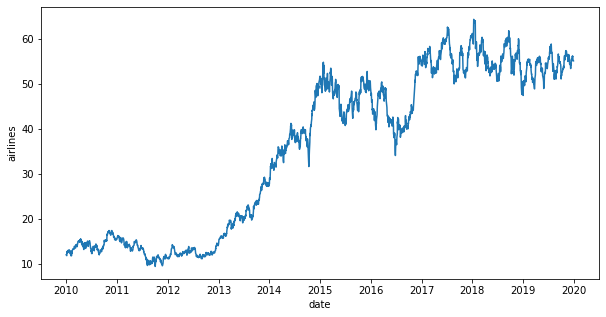

In [0]:
plt.figure(figsize=(10,5))
sns.lineplot(y='airlines', x='date', data=stock_agg)

In [0]:
# positive
airline_corr = pd.DataFrame(stock_agg.corr()['airlines'].sort_values()).reset_index()
airline_corr.columns = ['sub_industry', 'correlation']
airline_corr = airline_corr.merge(sub_industry_count, on='sub_industry')
airline_corr.tail(10)

,sub_industry,correlation,count
118,diversified banks,0.921348,6
119,home improvement retail,0.921926,2
120,multi-line insurance,0.926571,3
121,aerospace & defense,0.926853,11
122,movies & entertainment,0.942036,6
123,air freight & logistics,0.949861,4
124,property & casualty insurance,0.953698,8
125,pharmaceuticals,0.955688,9
126,reinsurance,0.956210,1
127,airlines,1.000000,5


In [0]:
# negative
airline_corr.head(10)

,sub_industry,correlation,count
0,alternative carriers,-0.780033,1
1,fertilizers & agricultural chemicals,-0.750149,4
2,copper,-0.745741,1
3,gold,-0.658103,1
4,oil & gas exploration & production,-0.593422,12
5,broadcasting,-0.521109,2
6,health care technology,-0.512643,1
7,interactive media & services,-0.460916,4
8,"apparel, accessories & luxury goods",-0.441400,10
9,publishing,-0.439794,2


### Chemicals

In [0]:
chemicals_col = [col for col in industry if 'chemicals' in col]
#chemicals_col = ['specialty chemicals','fertilizers & agricultural chemicals']

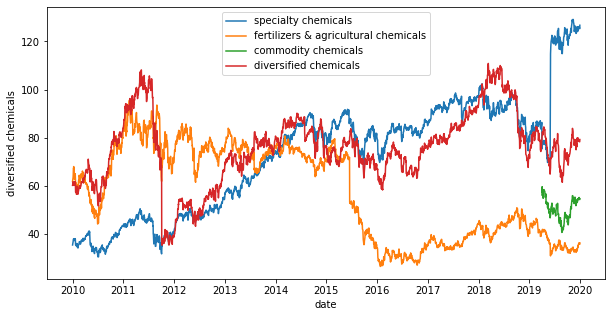

In [0]:
plt.figure(figsize=(10,5))
for col in chemicals_col:
  sns.lineplot(y=col, x='date', data=stock_agg, label=col)

In [0]:
# positive
sp_chemicals_corr = pd.DataFrame(stock_agg.corr()['specialty chemicals'].sort_values()).reset_index()
sp_chemicals_corr.columns = ['sub_industry', 'correlation']
sp_chemicals_corr = sp_chemicals_corr.merge(sub_industry_count, on='sub_industry')
sp_chemicals_corr.tail(10)

,sub_industry,correlation,count
118,aerospace & defense,0.911487,11
119,multi-line insurance,0.917371,3
120,diversified banks,0.925061,6
121,electric utilities,0.927273,13
122,specialized reits,0.928041,9
123,industrial machinery,0.928963,13
124,pharmaceuticals,0.929868,9
125,property & casualty insurance,0.937481,8
126,reinsurance,0.938376,1
127,specialty chemicals,1.000000,8


In [0]:
sp_chemicals_corr.head(10)

,sub_industry,correlation,count
0,copper,-0.755229,1
1,alternative carriers,-0.738255,1
2,fertilizers & agricultural chemicals,-0.644352,4
3,gold,-0.641583,1
4,interactive media & services,-0.521819,4
5,oil & gas exploration & production,-0.506917,12
6,health care technology,-0.472838,1
7,commodity chemicals,-0.331772,1
8,broadcasting,-0.316970,2
9,"apparel, accessories & luxury goods",-0.293204,10


In [0]:
# positive
fa_chemicals_corr = pd.DataFrame(stock_agg.corr()['fertilizers & agricultural chemicals'].sort_values()).reset_index()
fa_chemicals_corr.columns = ['sub_industry', 'correlation']
fa_chemicals_corr = fa_chemicals_corr.merge(sub_industry_count, on='sub_industry')
fa_chemicals_corr.tail(10)

,sub_industry,correlation,count
118,commodity chemicals,0.483164,1
119,oil & gas equipment & services,0.600447,5
120,copper,0.617199,1
121,broadcasting,0.659972,2
122,"apparel, accessories & luxury goods",0.737461,10
123,oil & gas storage & transportation,0.737787,3
124,publishing,0.773161,2
125,alternative carriers,0.795820,1
126,oil & gas exploration & production,0.858376,12
127,fertilizers & agricultural chemicals,1.000000,4


In [0]:
fa_chemicals_corr.head(10)

,sub_industry,correlation,count
0,construction materials,-0.853298,2
1,leisure products,-0.830052,1
2,packaged foods & meats,-0.821343,12
3,gas utilities,-0.799535,1
4,property & casualty insurance,-0.781616,8
5,interactive home entertainment,-0.780760,3
6,home improvement retail,-0.773063,2
7,water utilities,-0.771794,1
8,reinsurance,-0.771405,1
9,specialized reits,-0.753659,9


### Oil & Gas

In [0]:
og_cols

['upstream', 'midstream', 'downstream', 'integrated', 'services']

Text(0, 0.5, 'stock price')

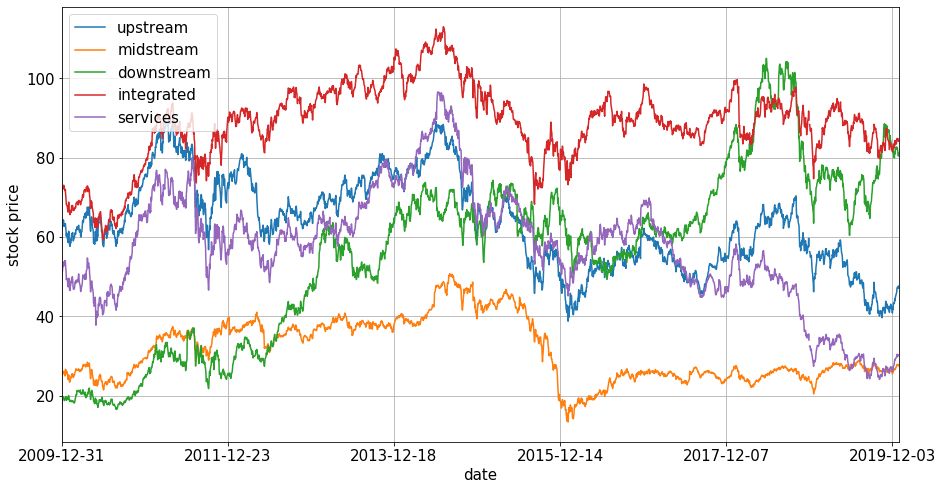

In [0]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

og_cols = list(oil.keys())
df_price_agg.set_index('date')[og_cols].plot(figsize=(15,8), grid=True)
plt.ylabel('stock price')


In [0]:
for col in og_cols:
  print('-'*10, col, '-'*10)
  print(df_price_agg.corr()[col].sort_values())
  print('\n')

---------- upstream ----------
construction materials   -0.689520
leisure products         -0.674181
gas utilities            -0.663524
water utilities          -0.663182
specialized reits        -0.654346
                            ...   
midstream                 0.706236
publishing                0.768741
services                  0.769312
non-specialty             0.878873
upstream                  1.000000
Name: upstream, Length: 126, dtype: float64


---------- midstream ----------
wireless telecommunication services   -0.634262
interactive home entertainment        -0.514287
leisure products                      -0.500584
technology distributors               -0.497765
construction materials                -0.487366
                                         ...   
upstream                               0.706236
department stores                      0.710328
non-specialty                          0.739291
apparel, accessories & luxury goods    0.774915
midstream                 